<ipython-input-15-d7e78088d957>:21: FutureWarning: The default value of regex will change from True to False in a future version.
  fake_df.columns = ((fake_df.columns.str).replace("^ ","")).str.replace(" $","")
<ipython-input-15-d7e78088d957>:21: FutureWarning: The default value of regex will change from True to False in a future version.
  fake_df.columns = ((fake_df.columns.str).replace("^ ","")).str.replace(" $","")
<ipython-input-15-d7e78088d957>:25: FutureWarning: The default value of regex will change from True to False in a future version.
  real_df.columns = ((real_df.columns.str).replace("^ ","")).str.replace(" $","")
<ipython-input-15-d7e78088d957>:25: FutureWarning: The default value of regex will change from True to False in a future version.
  real_df.columns = ((real_df.columns.str).replace("^ ","")).str.replace(" $","")


Difference in news articles: 2064
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_8 (Bidirecti  (None, None, 128)         98816     
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)    

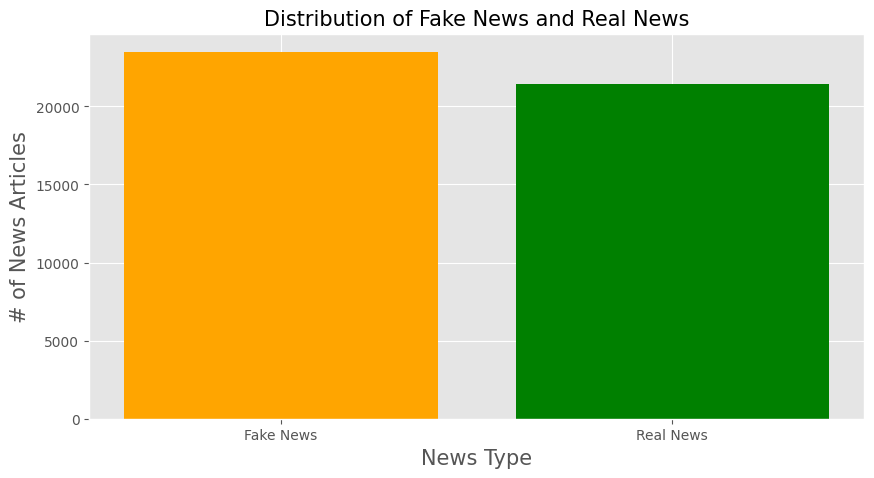

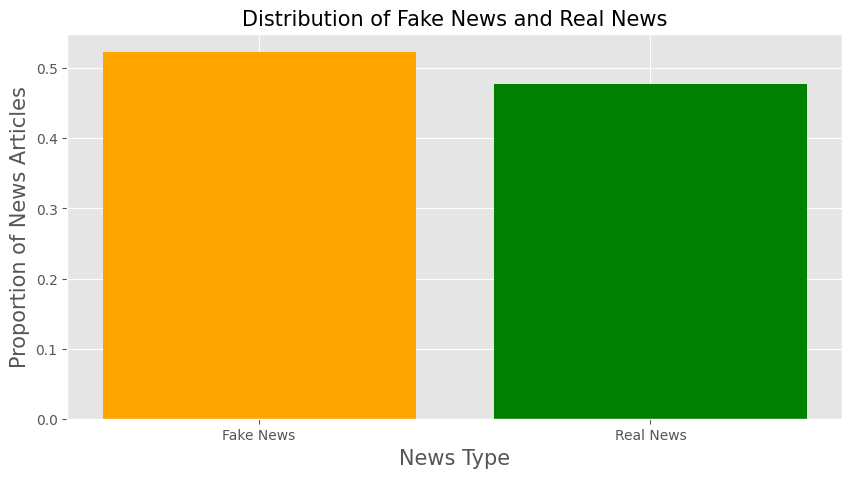

In [ ]:
# @title
#import the relevant modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import roc_auc_score
from keras import backend as K


plt.style.use('ggplot')


with open ('/content/drive/MyDrive/Fake.csv', "r") as file:
        fake_df = pd.read_csv(file, delimiter = ",")
        fake_df.columns = ((fake_df.columns.str).replace("^ ","")).str.replace(" $","")

with open ('/content/drive/MyDrive/True.csv', "r") as file:
        real_df = pd.read_csv(file, delimiter = ",")
        real_df.columns = ((real_df.columns.str).replace("^ ","")).str.replace(" $","")

fake_df.isnull().sum()
real_df.isnull().sum()
fake_df.subject.unique()
real_df.subject.unique()
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)


fake_df['isFake'] = 0 #Change to 1
real_df['isFake'] = 1 #Change to 0

#Plot the graph of the # of News Articles
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)

#Plot the graph of the ratio of News Articles
total_len = len(fake_df) + len(real_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df) / total_len, color='orange')
plt.bar('Real News', len(real_df) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)
print('Difference in news articles:',len(fake_df)-len(real_df))

#Concatenate both fake and real news
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df
# Combining the title with the text, it is much easier to process this way.

news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

# Split into training and testing
features = news_df['text']
targets = news_df['isFake']

#train_test_split is done to avoid data leakage
X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

# Normalizing our data: lower case, get rid of extra spaces, and url links.
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

#Tokenization
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

# Convert text to vectors

# tokenize the text into vectors
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Apply padding so we have the same length for each article

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256) #to avoid errors about data length inconsistencies
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

# Building the RNN.
model = tf.keras.Sequential([ #A recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()
# We are going to use early stop, which stops when the validation loss no longer improve.

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10,validation_split=0.2, batch_size=30, shuffle=True, callbacks=[early_stop])
# Visualize our training over time

history_dict = history.history

acc = history_dict['accuracy']


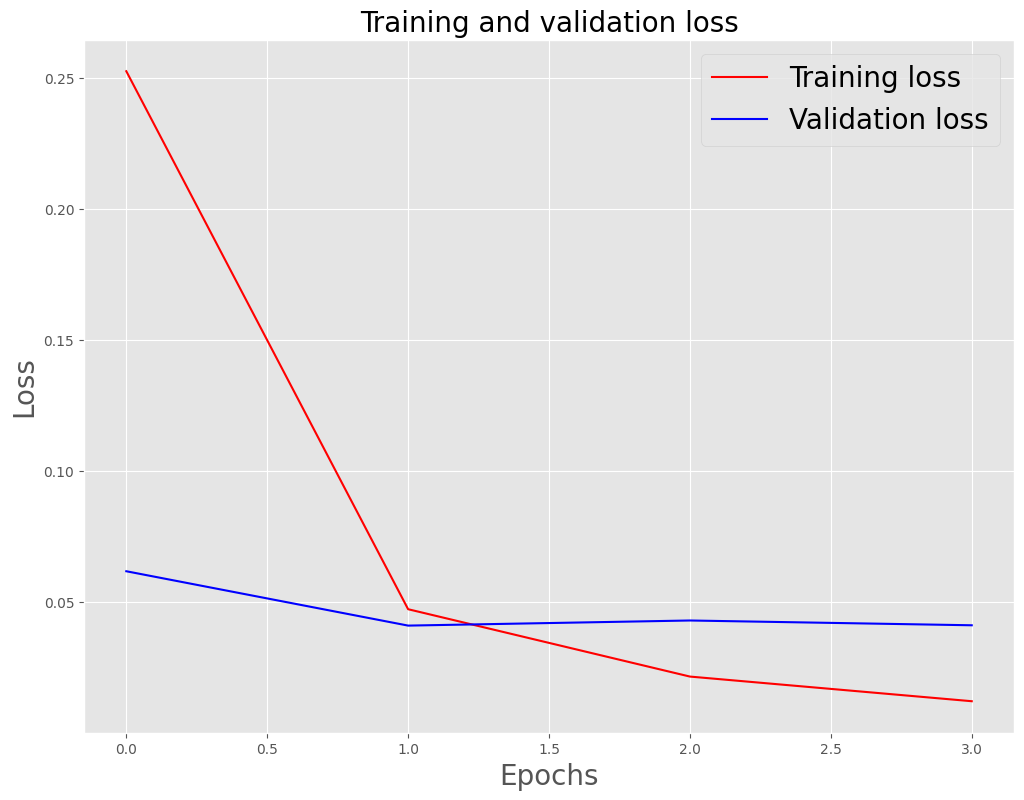

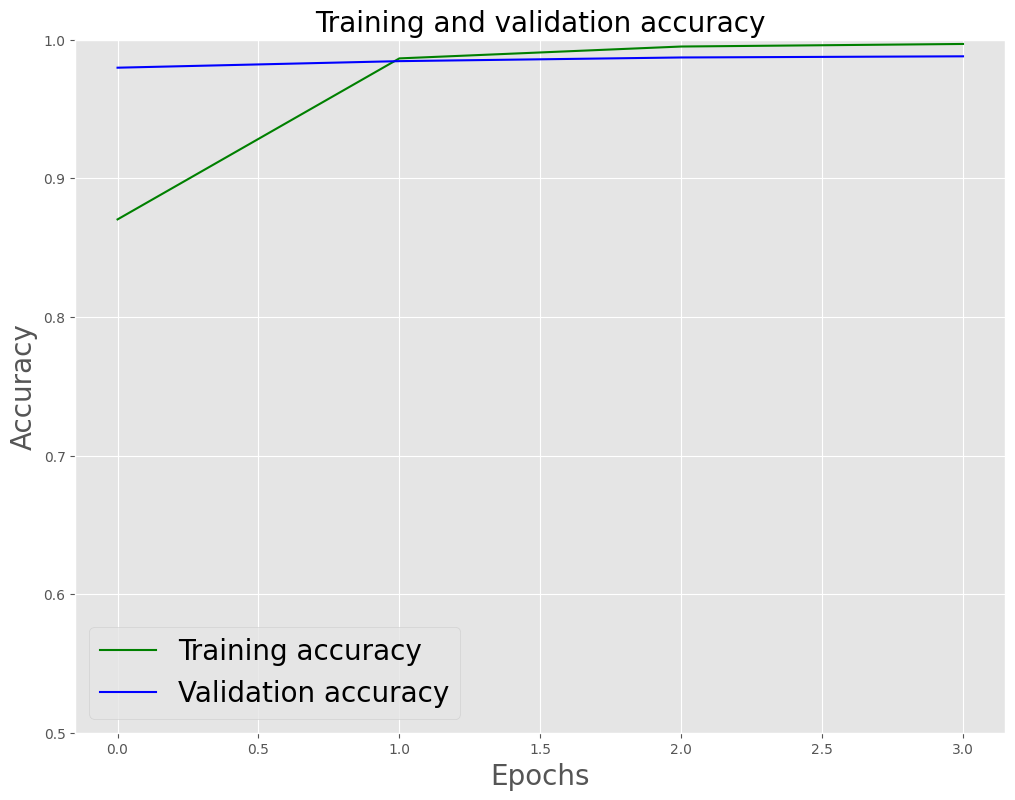

RNN Testing Data Results
281/281 [==============================] - 40s 141ms/step
Accuracy on testing set: 0.9876391982182628
Precision on testing set: 0.9807781380268643
Recall on testing set: 0.993431855500821
f1-score:  0.9870643947054711
ROC AUC : 0.9988


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

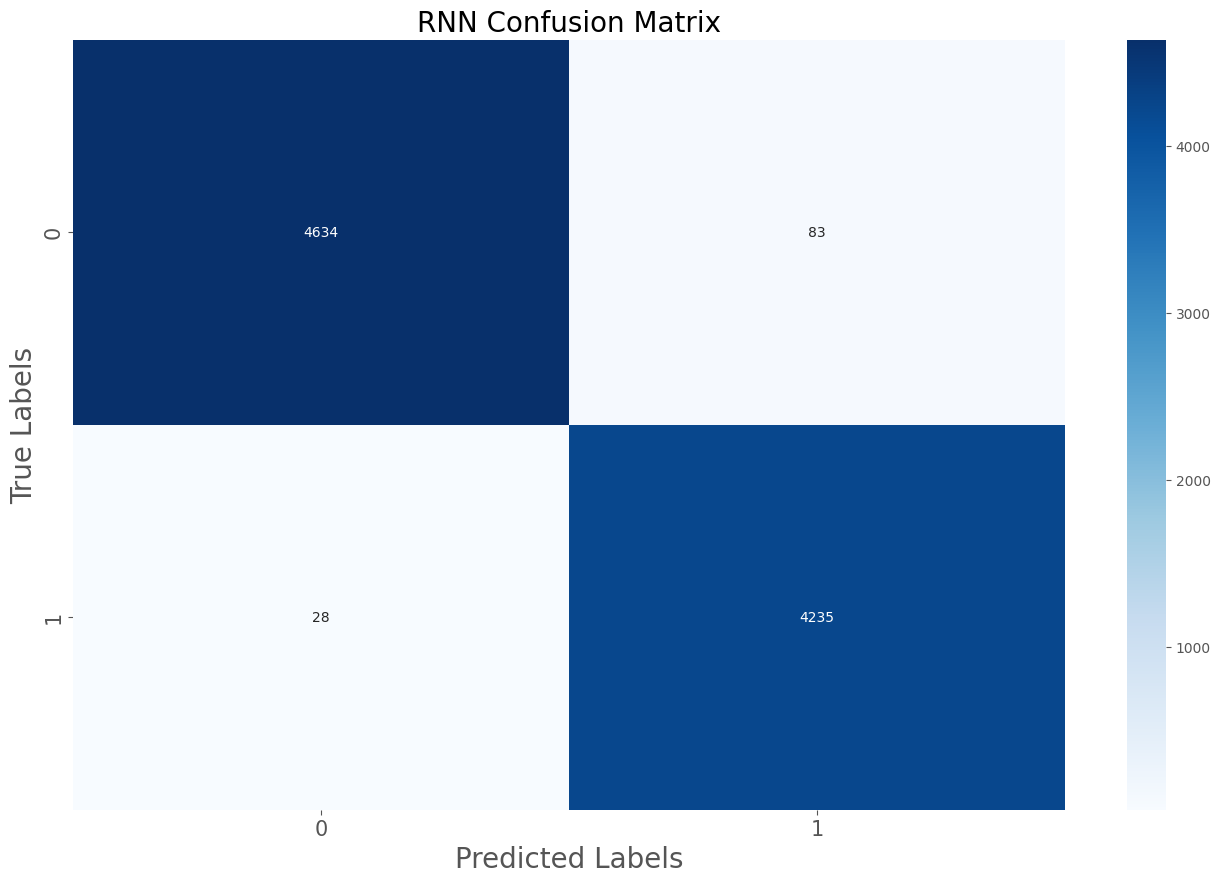

In [ ]:
validation_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
validation_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()


# Evaluate the testing set
print("RNN Testing Data Results")
model.evaluate(X_test, Y_test)
test_pred = model.predict(X_test)

binary_predictions = []

for i in test_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)
print('Accuracy on testing set:', accuracy_score(binary_predictions, Y_test))
precision = precision_score(binary_predictions, Y_test)
recall = recall_score(binary_predictions, Y_test)
print('Precision on testing set:', precision)
print('Recall on testing set:', recall)
print("f1-score: ", 2*((precision*recall)/(precision+recall+K.epsilon())))
ROC_AUC = roc_auc_score(Y_test, test_pred)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

# Confusion matrix

matrix = confusion_matrix(binary_predictions, Y_test, normalize=None)
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax = ax, cmap=plt.cm.Blues)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('RNN Confusion Matrix', size=20)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)
# Saves the weights for visualiation

In [ ]:
# Evaluate the training set
print("RNN Training Data Results")
model.evaluate(X_train, Y_train)
train_pred = model.predict(X_train)

binary_predictions = []

for i in train_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)
print('Accuracy on training set:', accuracy_score(binary_predictions, Y_train))
precision = precision_score(binary_predictions, Y_train)
recall = recall_score(binary_predictions, Y_train)
print('Precision on testing set:', precision)
print('Recall on testing set:', recall)
print("f1-score: ", 2*((precision*recall)/(precision+recall+K.epsilon())))
ROC_AUC = roc_auc_score(Y_train, train_pred)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

Training Data Results
1123/1123 [==============================] - 162s 145ms/step
Accuracy on training set: 0.9927891307979286
Precision on testing set: 0.9891806538394058
Recall on testing set: 0.9956439839886979
f1-score:  0.9924017454064059
ROC AUC : 0.9993


281/281 [==============================] - 65s 230ms/step


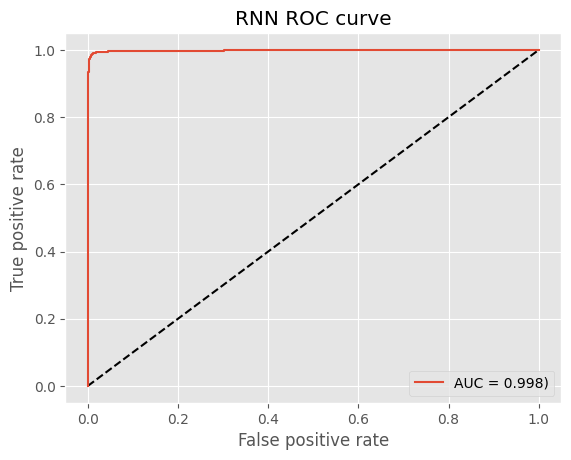

In [ ]:
#ROC Curve for RNN
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()

from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(Y_test, y_pred_keras)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f})'.format(roc_auc))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('RNN ROC curve')
plt.legend(loc='best')
plt.show()